In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import os
import sys
import re
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from dynamic_tasker.access import *
from dynamic_tasker.orbits import *
from dynamic_tasker.constants import *
from dynamic_tasker.cameras import *
from dynamic_tasker.schedulers import *
from dynamic_tasker.rotations import *

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
h = 400
# os.chdir("./exploration")
requests = load_worldcities(10000)
t0 = datetime.datetime(2024, 1, 1, 12, 0, 0)
orbit = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(51.6), Omega=np.pi, M=np.pi/2, t=t0)
t_end = datetime.datetime(2024, 1, 1, 13, 0, 0)
accesses = get_accesses(requests, orbit, 500, 30, t0, t_end)

np.random.seed(0)
for i, r in enumerate(accesses):
    r.state = {
        "occluded": np.random.randint(0, 2),
        "observed": False
        }
t_s = 10
t_dotsq = 4
# Camera matrix
width = 800
height = 600
K = get_intrinsics(300, width//2, height//2)

def agility_bangbang(theta):
    return t_s + t_dotsq * np.sqrt(np.abs(theta))

def roll_angle(t, r1, r2, agility):
    s = (r2.time - r1.time).total_seconds()
    t_s = agility(0)
    return (r1.angle + (r2.angle - r1.angle) * (((t - r1.time).total_seconds()) / (s)))

In [7]:
def get_latlonglines_eci(orbit, t):
    # Generate some latlong lines
    lats = np.linspace(-90, 90, 19)
    lons = np.linspace(-180, 180, 37)

    lats_fine = np.linspace(-90, 90, 181)
    lons_fine = np.linspace(-180, 180, 361)

    lat_lines_lons = np.repeat(lons, len(lats_fine))
    lat_lines_lats = np.tile(lats_fine, (len(lons),))

    long_lines_lats = np.repeat(lats, len(lons_fine))
    long_lines_lons = np.tile(lons_fine, (len(lats),))

    ecef_latlines = latlong2ecef_vec(np.stack([lat_lines_lats, lat_lines_lons], axis=1))
    ecef_lonlines = latlong2ecef_vec(np.stack([long_lines_lats, long_lines_lons], axis=1))

    eci_latlines = ecef2eci_vec(ecef_latlines, t)
    eci_lonlines = ecef2eci_vec(ecef_lonlines, t)

    orbit_propagated = propagate_orbit(orbit, (t-t0).total_seconds())
    r, v = kepler2eci(orbit_propagated)

    horizon = horizon_distance(orbit)

    # Calculate lat lines in horizon distance
    eci_latlines = eci_latlines[dist(eci_latlines, r) < horizon]
    eci_lonlines = eci_lonlines[dist(eci_lonlines, r) < horizon]

    return eci_latlines, eci_lonlines

In [8]:

# =============================================================================
# Projection and Data Processing Functions
# =============================================================================

def project_requests(requests, orbit, t, roll, r, horizon, t0):
    """
    Projects a list of requests into the camera/image frame.
    """
    if len(requests) == 0:
        return None

    # Convert each request's lat/long to ECEF then to ECI at time t
    requests_latlongs = np.array([[a.lat, a.long] for a in requests])
    requests_eci = ecef2eci_vec(latlong2ecef_vec(requests_latlongs), t)

    # Apply horizon filtering based on current satellite position
    requests_eci = requests_eci[dist(requests_eci, r) < horizon]

    return project_from_orbit(requests_eci, K, orbit, (t - t0).total_seconds(), roll)


def compute_projections(s, t0, orbit, schedule, accesses, requests, agility, width, box):
    """
    For a given time offset s (in seconds), compute all the projected data
    (e.g. lat/long lines, orbit, requests, schedule, etc.) required for plotting.
    """
    # Compute current time and satellite state
    t = t0 + datetime.timedelta(seconds=s)
    horizon = horizon_distance(orbit)
    r, v = kepler2eci(propagate_orbit(orbit, s))

    # Determine roll angle based on the schedule (if available)
    next_task_idx = next((i for i, a in enumerate(schedule) if a.time >= t), len(schedule))
    if 0 < next_task_idx < len(schedule):
        # print((t - schedule[next_task_idx - 1].time).total_seconds())
        roll = -slew_angle((t - schedule[next_task_idx - 1].time).total_seconds(), (schedule[next_task_idx].time - schedule[next_task_idx-1].time).total_seconds(),schedule[next_task_idx - 1].angle, schedule[next_task_idx].angle, agility)
        # print(roll, (t - schedule[next_task_idx - 1].time).total_seconds(), (schedule[next_task_idx].time - schedule[next_task_idx-1].time).total_seconds(), schedule[next_task_idx - 1].angle, schedule[next_task_idx].angle, agility)
    else:
        roll = 0

    # Compute latitude and longitude grid lines in ECI, then project them
    latlines, lonlines = get_latlonglines_eci(orbit, t)
    projected_latlines = project_from_orbit(latlines, K, orbit, (t - t0).total_seconds(), roll)
    projected_lonlines = project_from_orbit(lonlines, K, orbit, (t - t0).total_seconds(), roll)

    # Project the satellite's orbit (or current position)
    projected_orbit = project_from_orbit(
        (r * (Constants.R_E / (orbit.a + Constants.R_E)))[np.newaxis, :],
        K,
        orbit,
        (t - t0).total_seconds(),
        roll
    )

    # Compute the earth intersection point (camera line)
    r_unit = r / np.linalg.norm(r)
    v_unit = v / np.linalg.norm(v)
    intersect = earth_line_intersection(
        r,
        (r_unit * np.cos(np.deg2rad(roll))) + (np.cross(r_unit, v_unit) * np.sin(np.deg2rad(roll)))
    )
    projected_camera = None
    if intersect is not None:
        # Choose the closest intersection
        intersect = sorted(intersect, key=lambda x: np.linalg.norm(x - r))
        projected_camera = project_from_orbit(
            intersect[0][np.newaxis, :],
            K,
            orbit,
            (t - t0).total_seconds(),
            roll
        )

    # Classify and project requests
    requests_unobserved = [a for a in accesses if not a.state["observed"]]
    requests_occluded = [a for a in accesses if a.state["observed"]]
    requests_unoccluded = [a for a in accesses if a.state["observed"] and not a.state["occluded"]]

    proj_unobserved = project_requests(requests_unobserved, orbit, t, roll, r, horizon, t0)
    proj_occluded   = project_requests(requests_occluded, orbit, t, roll, r, horizon, t0)
    proj_unoccluded = project_requests(requests_unoccluded, orbit, t, roll, r, horizon, t0)

    # Project “other” requests (those not in the main request list)
    request_mask = np.ones(len(requests), dtype=bool)
    for a in accesses:
        request_mask[a.requestid] = False
    all_other_requests = [requests[i] for i in range(len(requests)) if request_mask[i]]
    proj_other = project_requests(all_other_requests, orbit, t, roll, r, horizon, t0)

    # Process scheduled requests
    requests_in_schedule = [requests[a.requestid] for a in schedule if a.time >= t]
    schedule_eci = None
    if len(requests_in_schedule) > 0:
        schedule_latlongs = np.array([[a.lat, a.long] for a in requests_in_schedule])
        schedule_eci = ecef2eci_vec(latlong2ecef_vec(schedule_latlongs), t)
        schedule_eci = schedule_eci[dist(schedule_eci, r) < horizon]

    # Build the full schedule projection
    proj_schedule = projected_camera
    if (projected_camera is not None) and (schedule_eci is not None):
        proj_schedule = np.concatenate([
            projected_camera,
            project_from_orbit(schedule_eci, K, orbit, (t - t0).total_seconds(), roll)
        ])

    # Return all computed projections along with some state parameters
    projections = {
        'latlines': projected_latlines,
        'lonlines': projected_lonlines,
        'orbit': projected_orbit,
        'requests_unobserved': proj_unobserved,
        'requests_occluded': proj_occluded,
        'requests_unoccluded': proj_unoccluded,
        'requests_other': proj_other,
        'schedule': proj_schedule,
        'camera': projected_camera
    }
    return projections, r, roll, t, horizon


def update_access_states(accesses, schedule, t, r, horizon, t0, orbit, agility, roll):
    """
    Update the 'observed' state for each access. If a request comes into view and is
    occluded in the schedule, this function tests for reachability based on agility.
    
    Reachability Test:
      - For an occluded scheduled request, we consider candidate replacements (not already in the schedule)
        between the current time t and the next scheduled request's time.
      - For a candidate to be "reachable", it must satisfy:
            candidate.time >= [prev_request.time or t] + agility(|candidate.angle - (prev_request.angle or a.angle)|)
        and next_request.time >= candidate.time + agility(|next_request.angle - candidate.angle|).
    """
    for a in accesses:
        proj = project_from_orbit(
            ecef2eci_vec(latlong2ecef_vec(np.array([[a.lat, a.long]])), t),
            K, 
            orbit,
            (t - t0).total_seconds(),
            roll
        )
        # Check if the request is within the horizon and the image frame bounds
        if (dist(ecef2eci_vec(latlong2ecef_vec(np.array([[a.lat, a.long]])), t), r)) < horizon \
           and 0 <= proj[0, 0] <= 800 and 0 <= proj[0, 1] <= 600:
            if not a.state["observed"]:
                a.state["observed"] = True
                if a in schedule and a.state["occluded"]:
                    idx = schedule.index(a)
                    # Only try swapping if a has a valid previous and next request.
                    if 0 < idx < len(schedule) - 1:
                        prev_req = schedule[idx - 1]
                        next_req = schedule[idx + 1]
                        # Find candidate replacements: accesses not already scheduled, with time in [t, next_req.time]
                        all_options = [x for x in accesses if x.time >= t and x.time <= next_req.time and x not in schedule]
                        # Only consider those that are unoccluded.
                        unoccluded_options = [x for x in all_options if not x.state["occluded"]]
                        
                        reachable_options = []
                        # Two cases depending on whether the current time t is past the previous request time.
                        if t > prev_req.time:
                            # For each candidate, require:
                            #   candidate.time >= t + agility(|candidate.angle - a.angle|)
                            #   and next_req.time >= candidate.time + agility(|next_req.angle - candidate.angle|)
                            for cand in unoccluded_options:
                                dt1 = datetime.timedelta(seconds=agility(abs(cand.angle - a.angle)))
                                dt2 = datetime.timedelta(seconds=agility(abs(next_req.angle - cand.angle)))
                                if (cand.time >= t + dt1) and (next_req.time >= cand.time + dt2):
                                    reachable_options.append(cand)
                        else:
                            # Otherwise, require:
                            #   candidate.time >= prev_req.time + agility(|candidate.angle - prev_req.angle|)
                            #   and next_req.time >= candidate.time + agility(|next_req.angle - cand.angle|)
                            for cand in unoccluded_options:
                                dt1 = datetime.timedelta(seconds=agility(abs(cand.angle - prev_req.angle)))
                                dt2 = datetime.timedelta(seconds=agility(abs(next_req.angle - cand.angle)))
                                if (cand.time >= prev_req.time + dt1) and (next_req.time >= cand.time + dt2):
                                    reachable_options.append(cand)
                        if reachable_options:
                            print(f"Swapping {a.name} for {reachable_options[0].name}")
                            schedule[idx] = reachable_options[0]
                        else:
                            print(f"Removing {a.name} from schedule")
                            schedule.remove(a)
                    else:
                        print(f"Removing {a.name} from schedule")
                        schedule.remove(a)


# =============================================================================
# Plot Setup and Update Functions
# =============================================================================

def setup_figure(box, width, height):
    """
    Create the matplotlib figure and all the plot elements.
    """
    fig, ax = plt.subplots(dpi=150)
    ax.set_xlim([-200, width + 200])
    ax.set_ylim([-200, height + 200])

    lat_line, = ax.plot([], [], 'b.', label='Latitude Lines', markersize=1)
    lon_line, = ax.plot([], [], 'r.', label='Longitude Lines', markersize=1)
    req_unobs_line, = ax.plot([], [], '.', label='Requests', markerfacecolor='none', markeredgecolor='black')
    req_occ_line, = ax.plot([], [], '.', label='Requests', markerfacecolor='red', markeredgecolor='none')
    req_unocc_line, = ax.plot([], [], '.', label='Requests', markerfacecolor='green', markeredgecolor='none')
    req_other_line, = ax.plot([], [], '.', label='Requests', markerfacecolor='white', markeredgecolor='black')
    schedule_line, = ax.plot([], [], 'c', label='Schedule', markerfacecolor='limegreen', markeredgecolor='black')
    orbit_line, = ax.plot([], [], 'yo', label='Orbit')
    camera_line, = ax.plot([], [], 'ko', label='Camera')
    box_line, = ax.plot(box[:, 0], box[:, 1], 'k-', label='Box')

    elements = {
        'lat_line': lat_line,
        'lon_line': lon_line,
        'req_unobs_line': req_unobs_line,
        'req_occ_line': req_occ_line,
        'req_unocc_line': req_unocc_line,
        'req_other_line': req_other_line,
        'schedule_line': schedule_line,
        'orbit_line': orbit_line,
        'camera_line': camera_line,
        'box_line': box_line
    }
    return fig, ax, elements


def update_plot_elements(elements, projections):
    """
    Update each plot element (line) with its new data.
    """
    if projections['latlines'] is not None:
        elements['lat_line'].set_data(projections['latlines'][:, 0], projections['latlines'][:, 1])
    if projections['lonlines'] is not None:
        elements['lon_line'].set_data(projections['lonlines'][:, 0], projections['lonlines'][:, 1])
    if projections['orbit'] is not None:
        elements['orbit_line'].set_data(projections['orbit'][:, 0], projections['orbit'][:, 1])
    if projections['requests_unobserved'] is not None:
        elements['req_unobs_line'].set_data(projections['requests_unobserved'][:, 0], projections['requests_unobserved'][:, 1])
    if projections['requests_occluded'] is not None:
        elements['req_occ_line'].set_data(projections['requests_occluded'][:, 0], projections['requests_occluded'][:, 1])
    if projections['requests_unoccluded'] is not None:
        elements['req_unocc_line'].set_data(projections['requests_unoccluded'][:, 0], projections['requests_unoccluded'][:, 1])
    if projections['requests_other'] is not None:
        elements['req_other_line'].set_data(projections['requests_other'][:, 0], projections['requests_other'][:, 1])
    if projections['schedule'] is not None:
        elements['schedule_line'].set_data(projections['schedule'][:, 0], projections['schedule'][:, 1])
    if projections['camera'] is not None:
        elements['camera_line'].set_data(projections['camera'][:, 0], projections['camera'][:, 1])


# =============================================================================
# Animation / Analysis Driver
# =============================================================================

def run_animation(accesses, requests, orbit, schedule, t0, box, agility, s_values, width=800, height=600, save_path='animation.mp4'):
    """
    Main driver function to set up the simulation, run the animation, and/or
    perform analysis. (If you wish to run headless analysis, you can call the
    projection functions without starting the animation.)
    """
    # Initialize state for accesses and schedule
    for a in accesses:
        a.state["observed"] = False
    start_latlong = ecef2latlong(eci2ecef(kepler2eci(orbit)[0], t0))
    # Insert a starting access into the schedule.
    schedule.insert(0, Access(Request(-1, start_latlong[0], start_latlong[1], "Start"), t0, 0, {"observed": True, "occluded": False}))
    print(schedule)

    # Set up the figure and plot elements
    fig, ax, elements = setup_figure(box, width, height)

    def update(frame):
        if(frame % 100 == 0):
            print(f"Frame {frame+1}/{len(s_values)}")
        
        s = s_values[frame]
        # Compute all projection data for current time step
        projections, r, roll, t, horizon = compute_projections(s, t0, orbit, schedule, accesses, requests, agility, width, box)
        # Update request states if needed (e.g., swap or remove occluded ones with reachability tests)
        update_access_states(accesses, schedule, t, r, horizon, t0, orbit, agility, roll)
        # Update the plot elements with the new projection data
        update_plot_elements(elements, projections)
        return tuple(elements.values())

    ani = animation.FuncAnimation(fig, update, frames=len(s_values), interval=10, blit=True, repeat=False)
    ani.save(save_path, writer='ffmpeg', fps=20)
    plt.show()


[Access(-1, 51.60000000000001, -10.337452905252599, Start, 2024-01-01 12:00:00, 0, {'observed': True, 'occluded': False}, 1), Access(7186, 53.2719, -9.0489, Galway, 2024-01-01 12:00:12.207031, 24.901537330328182, {'occluded': 0, 'observed': False}, 1), Access(9987, 53.3544, -6.4486, Lucan, 2024-01-01 12:00:37.597656, 26.688934770432116, {'occluded': 0, 'observed': False}, 1), Access(8480, 51.6159, -3.4175, Rhondda, 2024-01-01 12:01:08.847656, 3.805823874766654, {'occluded': 1, 'observed': False}, 1), Access(3003, 51.56, -1.78, Swindon, 2024-01-01 12:01:25.449219, 4.738605812134059, {'occluded': 1, 'observed': False}, 1), Access(9177, 51.4496, -0.4089, Feltham, 2024-01-01 12:01:39.121094, 4.863097195551908, {'occluded': 1, 'observed': False}, 1), Access(9284, 51.34, 0.74, Sittingbourne, 2024-01-01 12:01:50.839844, 4.901003760951713, {'occluded': 0, 'observed': False}, 1), Access(6949, 51.0383, 2.3775, Dunkerque, 2024-01-01 12:02:07.441406, 3.1457822213924054, {'occluded': 1, 'observed':

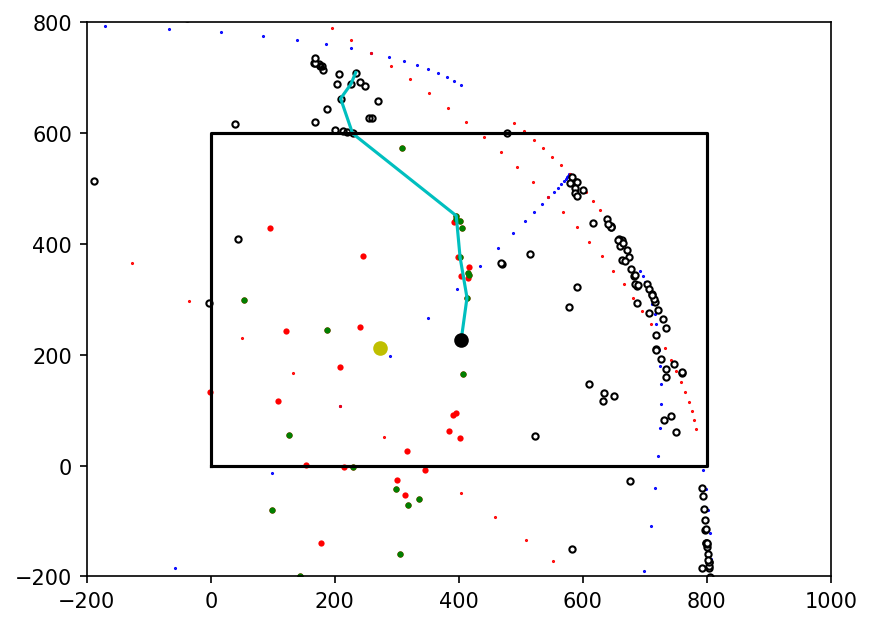

In [9]:
schedule = milp_schedule(accesses, requests, agility_bangbang)
# schedule = greedy_schedule(accesses, requests, agility_bangbang)
s_values = range(0, 800, 1)  # simulation seconds

box = np.array([
    [0, 0],
    [width, 0],
    [width, height],
    [0, height],
    [0, 0]
])

run_animation(accesses, requests, orbit, schedule, t0, box, agility_bangbang, s_values, save_path='animation.gif')